In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [3]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset


from counterfactuals.optimizers.approach_three import ApproachThree
from counterfactuals.optimizers.approach_gen_disc_loss import ApproachGenDiscLoss

from counterfactuals.discriminative_models import LogisticRegression

from counterfactuals.utils import plot_loss_space, plot_model_distribution

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

In [5]:
disc_model = LogisticRegression(dataset.X_train.shape[1], 1)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0)
disc_model.fit(train_loader=train_dataloader, epochs=200)
print(classification_report(dataset.y_test, disc_model.predict(dataset.X_test)))

Epoch 199, Loss: 0.2667: 100%|██████████| 200/200 [00:00<00:00, 203.92it/s]


              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89        52
         1.0       0.84      0.96      0.90        51

    accuracy                           0.89       103
   macro avg       0.90      0.89      0.89       103
weighted avg       0.90      0.89      0.89       103



In [6]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
cf = ApproachGenDiscLoss(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=torch.nn.BCELoss(),
    checkpoint_path="model.pt",
    neptune_run=None,
)

In [7]:
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=100,
)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 99, Train: 0.6260, test: 0.5718: 100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


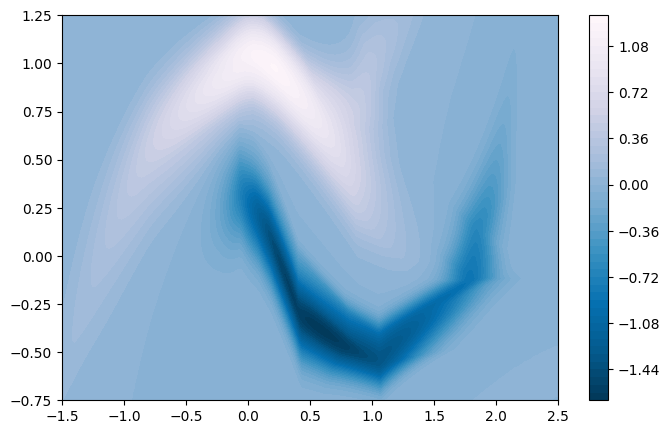

In [8]:
plot_model_distribution(cf.gen_model)

tensor([0.9784], grad_fn=<AddBackward0>) 0.424550324678421 0.0 0.0
tensor(3.3647)


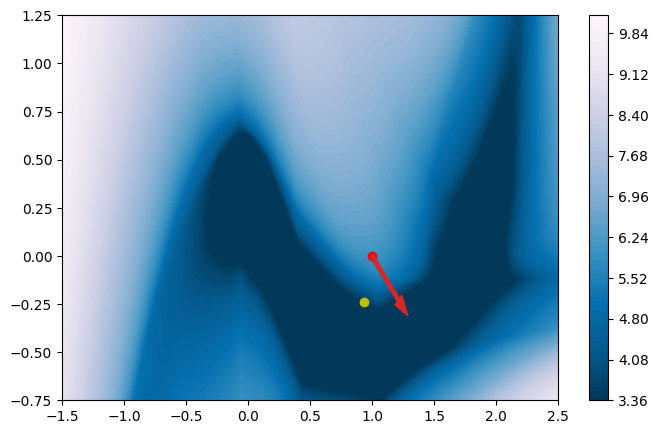

tensor([0.9723], grad_fn=<AddBackward0>) 0.42690688371658325 0.0 0.0
tensor(3.3647)


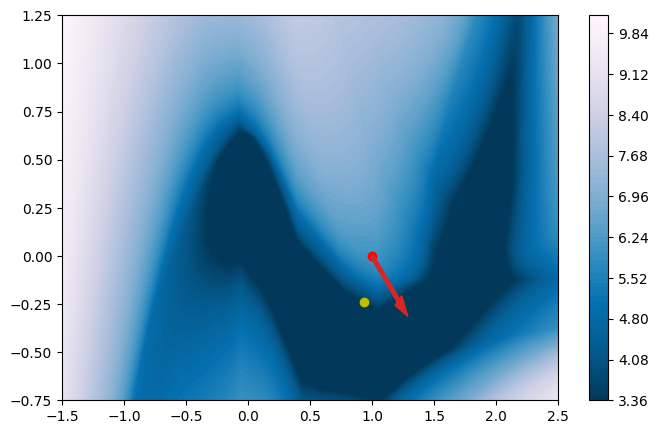

tensor([0.9646], grad_fn=<AddBackward0>) 0.4298553466796875 0.0 0.0
tensor(3.3647)


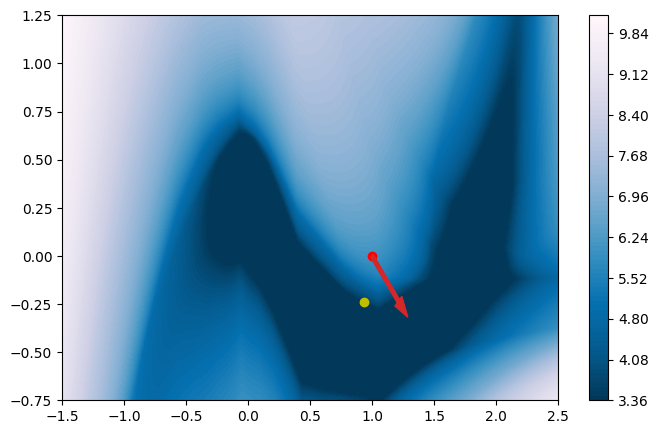

tensor([0.9560], grad_fn=<AddBackward0>) 0.4333033859729767 0.0 0.0
tensor(3.3647)


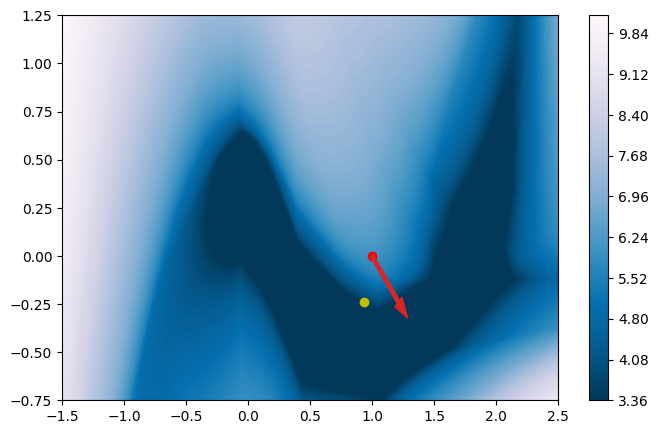

tensor([0.9466], grad_fn=<AddBackward0>) 0.43714192509651184 0.0 0.0
tensor(3.3647)


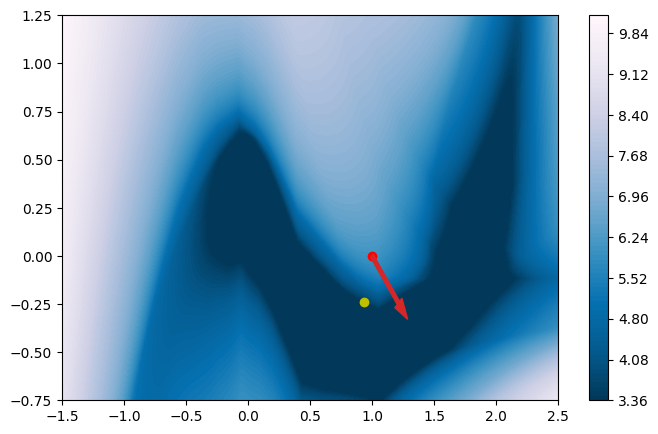

In [9]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)
optimizer = torch.optim.Adam([x], lr=0.01)
alpha = 20

num_iterations = 500
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1])

for i in range(num_iterations):
    y, dist, max_inner, max_outer = cf.search_step(x_param=x, x_origin=x_origin, context_origin=context_origin, context_target=context_target, alpha=alpha, beta=0.1)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        print(y, dist.detach().item(), max_inner.detach().item(), max_outer.detach().item())
        plot_loss_space(x, x_origin, cf.search_step, alpha=alpha, beta=0.01)